# New calibrator algorithm

This tests out the new calibrator detection algorithm with proper timing and everything.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# global settings, fine for notebook
fcomb = np.arange(50e3,51.2e6,100e3)
Nb = len(fcomb)
kcomb = np.arange(1,2*Nb,2)
print (fcomb[0], fcomb[-1], Nb)
# true response
true_resp = np.exp(-(fcomb-30e6)**2/(2*25e6**2))
# our transmission code
code = np.exp(2*np.pi*1j*np.random.uniform(0,2*np.pi,Nb))
code_resp = code #* true_resp
dt = 4096/102.4e6  # time between frames 
phase_drift_per_ppm = fcomb*dt*(1/1e6)*2*np.pi
Nnotch = 16 #
alpha_to_pdrift = (Nnotch*phase_drift_per_ppm/kcomb)[0]


50000.0 51150000.0 512


In [3]:
def produce_data(alpha = -0.5, dalpha_dt = +0.0, sA=1, sc=None, ssig=None, Nintg = 64, add_noise = True):
    istart = 0
    last_phase = np.zeros(Nb)
    Nblock = Nnotch*Nintg
    while True:
        iend = istart+Nblock
        tar = np.arange(istart, iend)*dt
        alpha_ar = -(alpha+dalpha_dt*tar) #silly signs
        ampl_ar = sA*np.exp(-(tar-sc)**2/(2*ssig**2)) if sc is not None else sA*np.ones_like(tar)
        phase = last_phase + np.cumsum(np.outer(alpha_ar,phase_drift_per_ppm),axis=0)
        #print(alpha_ar,phase_drift_per_ppm)
        #print (phase[:,0])
        rot = np.exp(-1j*phase)
        data = code_resp[None,:]*ampl_ar[:,None]*rot
        t = tar.mean()
        calpha = alpha_ar.mean()
        dB = np.log10(ampl_ar.mean())*20 ## power is square of amplitude
        if add_noise:
            data += np.random.normal(0,1.0/np.sqrt(Nnotch), data.shape)
        ## integrate here
        data = data.reshape(Nintg,Nnotch,data.shape[1]).mean(axis=1)
        yield (t, calpha, dB, data)
        istart += Nblock
        last_phase = phase[-1,:]


In [15]:
def use_refspec_data(filename, Nintg=64, add_noise=False, SNR_dB=0):
    
    d=np.fromfile(open(filename,'rb'),dtype=np.csingle)
    d = d.reshape((-1,2048)) 
    # and now take just 50, 150, etc
    d = d[:,1::4]*1e7
    istart = 0
    if add_noise:
        rms_signal = np.sqrt((np.abs(d)**2).mean())
        rms_noise = rms_signal/Nnotch*10**(-SNR_dB/20)
        print (rms_noise)
    while True:
        iend = istart+Nintg
        if iend > d.shape[0]:
            break
        t = (istart+iend)/2*dt*Nnotch
        calpha = 0 
        data = d[istart:iend,:]
        if add_noise:
            
            data += np.random.normal(0,rms_noise, data.shape)
            
        yield (t,calpha, SNR_dB, data)
        istart = iend
        

In [35]:
def analyze_data (data_gen, tmax=30, countmax=None, Nintg = 64, alpha_start = 0, force_detect=False, maxdriftndx=None ):
    # Now we do the relatively 
    init_phase = np.ones(Nb, complex)
    detect = False
    pdrift = alpha_start*alpha_to_pdrift
    drift = []
    nullw = (-1)**np.arange(Nintg)
    Nblock = Nnotch*Nintg
    count = 0 
    for t, alpha, dB, data in data_gen:

        if t>tmax:
            break
        count += 1
        if countmax is not None:
            if count>countmax:
                break
        assert(data.shape[0]==Nintg)
        kar = np.outer(np.arange(Nintg+1),kcomb)
        
        if True:
        ## the actual statement
            phase_cor = np.exp(-1j*pdrift*kar)
        ## the "fast" statement
        else:
            tab = pdrift*kcomb
            phase_step = 1-(tab)**2/2 + 1j*tab
            phase_cor = np.array([phase_step**i for i in range(Nintg+1)])
        phase1 = init_phase*phase_cor
        init_phase = phase1[-1,:]
        data *= phase1[:-1,:]
        kar = kar[:-1,:]
        
        sum0 = data.sum(axis=0)
        sum0null = (data*nullw[:,None]).sum(axis=0)
        sum1 = (1j*kar*data).sum(axis=0)
        sum2 = (-kar**2*data).sum(axis=0)
        FD = np.real(sum1*np.conj(sum0))
        SD = np.real(sum2*np.conj(sum0)+sum1*np.conj(sum1))
        sig2 = np.abs(sum0**2)
        noise2 = np.abs(sum0null**2)
        SNRdB = np.log10(sig2.sum()/noise2.sum())*10
        print (sum0[2],sum1[2],sum2[2],'sums')
        print (FD[2], SD[2],'FDSD')
        yield t, alpha, dB, pdrift/alpha_to_pdrift, SNRdB, detect, sum0
        if maxdriftndx is not None:
            FD = FD[:maxdriftndx]
            SD = SD[:maxdriftndx]
        delta_drift = (FD.sum()/SD.sum())
        if force_detect:
            pdrift += delta_drift    
            print ('new pdrift = ', pdrift/alpha_to_pdrift)
        else:
            if np.abs(delta_drift)>0.05*alpha_to_pdrift:
                delta_drift = +0.05*alpha_to_pdrift
            pdrift = pdrift+delta_drift
            if np.abs(pdrift)>1.2*alpha_to_pdrift:
                pdrift = np.sign(pdrift)*1.2*alpha_to_pdrift*(-1)
       
        

    return 



In [44]:
data = use_refspec_data('../../refspec/calibrator_review22/notch_03.bin', Nintg=8, add_noise=False, SNR_dB=-10)
ana = analyze_data(data,tmax=30,Nintg=8, alpha_start=0.25, force_detect=True, maxdriftndx=500)

_,_,_,_,_,_, sum0=next(ana)
sum  = sum0
print (sum[2])
for i in range(2):
    _,_,_,_,_,_, sum0=next(ana)
    sum += sum0
    print (sum[2])



(1.0493556+13.305055j) (-232.83976078033447+18.345968052744865j) (-458.363613858819-5821.02028131485j) sums
-0.23760513908774783 -23379.050739677565 FDSD
(1.0493556+13.305055j)
new pdrift =  0.2996125033432962
(1.0467411+13.305349j) (-232.8437203168869+18.316777423024178j) (-458.01468975842-5821.089068055153j) sums
-0.015975865642957388 -23379.34403460793 FDSD
(2.0960968+26.610405j)
new pdrift =  0.3024886317992552
(1.0465567+13.305388j) (-232.844717502594+18.31529349088669j) (-457.7885143458843-5821.125513315201j) sums
0.006892714320372306 -23379.325371965824 FDSD
(3.1426535+39.915794j)


In [6]:

res=[]
for Nintg in [128]:#, 128, 256]:
    data = produce_data(alpha=+0.9, dalpha_dt=-0.00, sc=15, ssig=3.5, Nintg=Nintg, add_noise=True)
    #data = use_refspec_data('../../refspec/calibrator_review22/03filtnotch.bin', Nintg=Nintg, add_noise=True, SNR_dB=-10)
    res.append ( list(analyze_data(data,tmax=30,Nintg=Nintg, alpha_start=+0.3, force_detect=False, maxdriftndx=500))) 


In [7]:

sum1 = np.array([x[6] for x in res[0]])
t1, inalpha1, inSNR1, alpha1, SNR1, detect1, _  = np.array(res[0]).T
#t2, inalpha2, inSNR2, alpha2, SNR2, detect2 =res[1].T
#t3, inalpha3, inSNR3, alpha3, SNR3, detect3 =res[2].T
sum1.shape

/tmp/ipykernel_4006021/1179293813.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  t1, inalpha1, inSNR1, alpha1, SNR1, detect1, _  = np.array(res[0]).T


(366, 512)

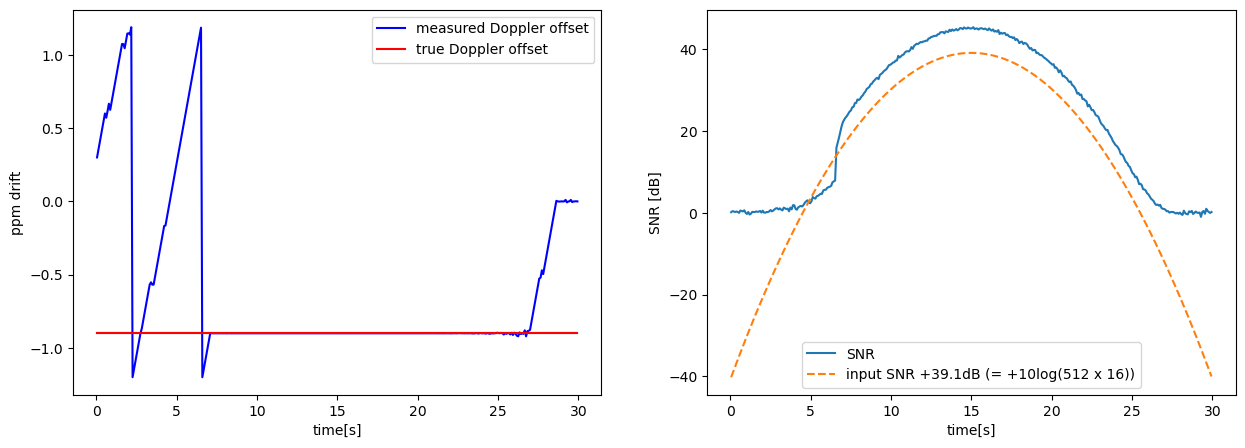

In [8]:

fig=plt.figure(figsize=(15,5))
ax1,ax2 = fig.subplots(nrows=1, ncols=2)
#inalpha1 = 0.3*np.ones_like(t1)
ax1.plot(t1,inalpha1)
ax1.plot (t1,alpha1,'b-', label='measured Doppler offset')
ax1.plot (t1,inalpha1,'r-', label='true Doppler offset')
ax1.set_xlabel('time[s]')
ax1.set_ylabel('ppm drift')
ax1.legend()

ax2.plot(t1,SNR1,label='SNR')
ax2.plot(t1,inSNR1+39.1,'--',label='input SNR +39.1dB (= +10log(512 x 16))')
ax2.set_xlabel('time[s]')
ax2.set_ylabel('SNR [dB]')
ax2.legend()

#plt.plot(t2,inalpha2,label='real Doppler offset')
#plt.plot (t2,-alpha2,'g-',label='measured Doppler offset')
#plt.plot(t2,detect2, label='detect flag')

#plt.plot(t3,inalpha3)
#plt.plot (t3,-alpha3,'b-')
#plt.plot(t3,detect3)

#plt.legend()
#plt.ylabel('ppm drift')

In [46]:
#Sum in bins of SNR
dSNR = 5
SNRbins = np.arange(1,45,dSNR)
sums = []
for s in SNRbins:
    w = np.where((SNR1>s) & (SNR1<s+dSNR))
    csum = sum1[w,:].sum(axis=1)[0]
    sums.append(csum)
    
#dt=7.5
#tbins = np.arange(0,30,dt)
#sums = []
#for s in tbins:
#    w = np.where((t1>s) & (t1<s+dt))
#    csum = sum1[w,:].sum(axis=1)[0]
#    sums.append(csum)

    
sums = np.array(sums)
#sumsc=sums

In [12]:


def phase_correct (avg):
    p = np.zeros(1025,complex)
    p[1::2] = avg*np.conj(code)
    guess = np.abs(np.fft.fft(p)).argmax()
    if guess>Nb//2:
        guess -= Nb
    rate_in = guess/(2*Nb)
    def fix (rate):
        return avg*np.exp(-1j*2*np.pi*rate*kcomb)
    def penalty (rate):
        pen = (np.imag(fix(rate)*np.conj(code))**2).sum()
        #print (rate,pen)
        return pen
    
    from scipy.optimize import minimize
    bounds = (rate_in-1/256,rate_in+1/256)
    #print (bounds)
    #res = minimize(penalty, rate_in,bounds = [bounds], method='powell')
    search = np.linspace(bounds[0],bounds[-1],10000)
    res = [penalty(x) for x in search]
    res = search[np.argmin(res)]
    print (rate_in, res)
    avgr = fix(res)
    return avgr


0.1328125 0.13239409878487848
0.1328125 0.132270648939894
0.1328125 0.132270648939894
0.1328125 0.13226361698669867
0.1328125 0.13225658503350335
0.1328125 0.13226986761176118
0.1328125 0.13226986761176118
0.1328125 0.13226908628362835


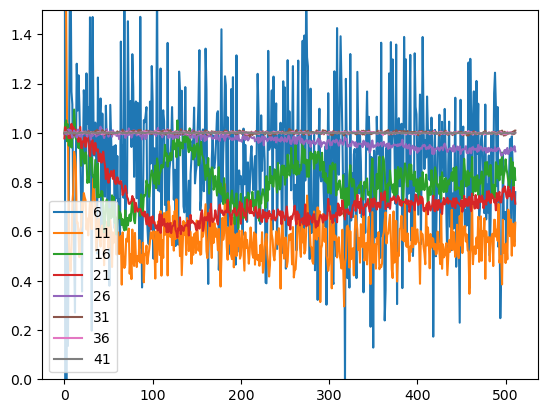

In [49]:


for i,v in enumerate(SNRbins[1:]):
    a = phase_correct(sums[i,:])

#def fix (rate):
#    return x*np.exp(-1j*2*np.pi*rate*kcomb)
#def penalty (rate):
#    pen = (np.imag(fix(rate)*np.conj(code))**2).sum()
    #    return pen
    u = np.real(a*np.conj(code))
    if np.real(u[0])<0:
        u = -u

    plt.plot(u/u[:10].mean(),label=str(v))


plt.ylim(0,1.5)

plt.legend()



15

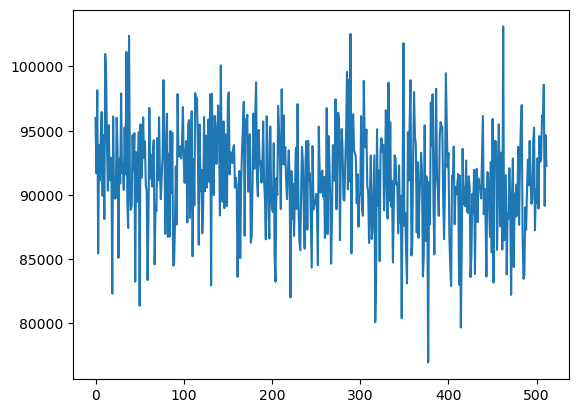

In [29]:
plt.plot(np.real(sums[5,:]*np.conj(sums[12,:])))
len(sums)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


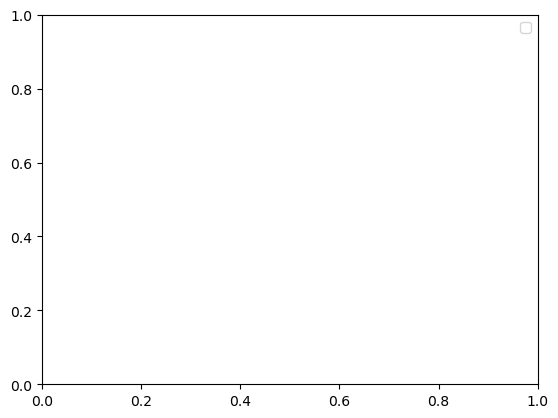

In [362]:

res=[]
alpha_out = {32:[], 64:[], 128:[]}
alpha_in = np.linspace(-0.5,0.5,100)
alpha_true = 0.0
for Nintg in [32, 64, 128]:
    for alpha_start in alpha_in:
        data = produce_data(alpha=alpha_true,  Nintg=Nintg, sA=0.1, add_noise=False)
        A = analyze_data(data,Nintg=Nintg, alpha_start=alpha_start, force_detect=True)
        next(A)
        alpha_out[Nintg].append(next(A)[3])
for Nintg in [32, 64, 128]:
    alpha_out[Nintg] = np.array(alpha_out[Nintg])   


0.36868686868686873
0.1868686868686869
0.08585858585858583


Text(0, 0.5, 'output Doppler offset [ppm]')

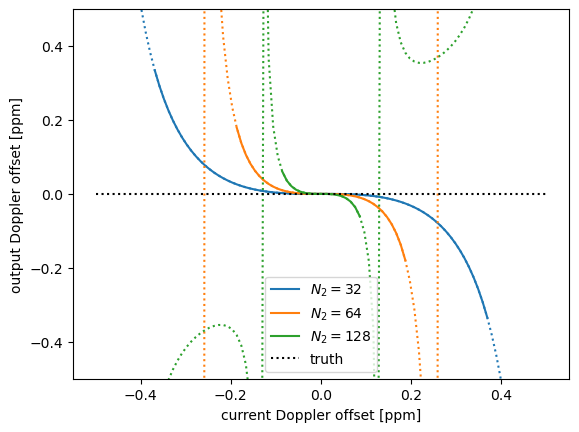

In [365]:
for Nintg in [32,64,128]:
    p=plt.plot(alpha_in, alpha_out[Nintg],':')
    
    w = np.where(np.abs(alpha_out[Nintg]-alpha_true)<np.abs(alpha_in-alpha_true))
    plt.plot(alpha_in[w], alpha_out[Nintg][w],color=p[0].get_color(),label=f'$N_2={Nintg}$')
    print ((alpha_in[w].max()-alpha_in[w].min())/2)

plt.plot(alpha_in, alpha_true*np.ones_like(alpha_in),'k:', label='truth')
plt.ylim(-0.5,0.5)
plt.legend()
plt.xlabel('current Doppler offset [ppm]')
plt.ylabel('output Doppler offset [ppm]')

In [178]:
Nintg = 32
res=[]
alpha_var = {32:[], 64:[], 128:[]}
dblist = np.linspace(-60,0,50)
alpha_true = 0.0
for dbsnr in dblist:
    snr = 10**(dbsnr/20)
    for Nintg in alpha_var.keys():
        data = produce_data(alpha=0,  Nintg=Nintg, sA=snr, add_noise=True)
        res = []
        for i in range(10): 
            res0 = np.array(list(analyze_data(data,Nintg=Nintg, alpha_start=0, countmax = 12,  force_detect=True)))[5:,3]
            res = np.hstack((res,res0))
        alpha_var[Nintg].append(np.sqrt(res.var()))


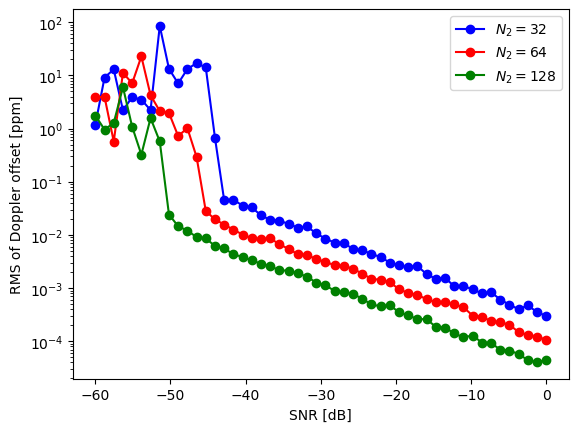

In [368]:
plt.semilogy()
plt.plot(dblist, np.array(alpha_var[32]),'bo-', label='$N_2=32$')
plt.plot(dblist, alpha_var[64],'ro-', label='$N_2=64$')
plt.plot(dblist, alpha_var[128],'go-', label='$N_2=128$')
plt.xlabel('SNR [dB]')
plt.ylabel('RMS of Doppler offset [ppm]')
plt.legend()

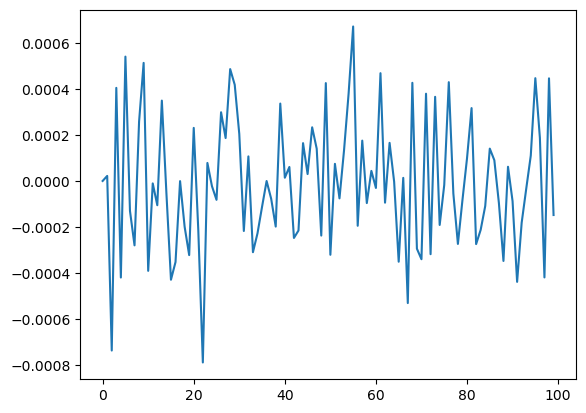

In [152]:
plt.plot(res[:,3])

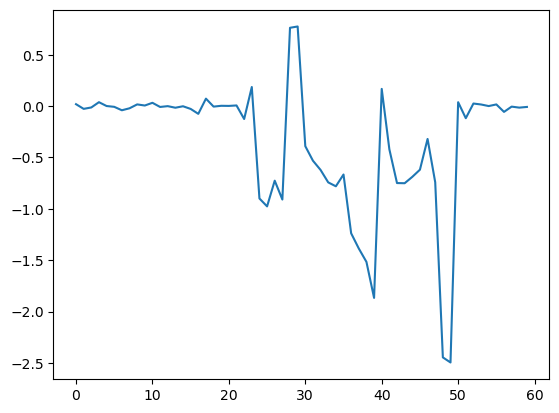

In [177]:
plt.plot(res)

In [234]:
data1 = next(use_refspec_data('../../refspec/calibrator_review22/03notch.bin', Nintg=1024))[3]
data2 = next(use_refspec_data('../../refspec/calibrator_review22/03filtnotch.bin', Nintg=1024+20))[3][20:,:]
data3 = data1-data2

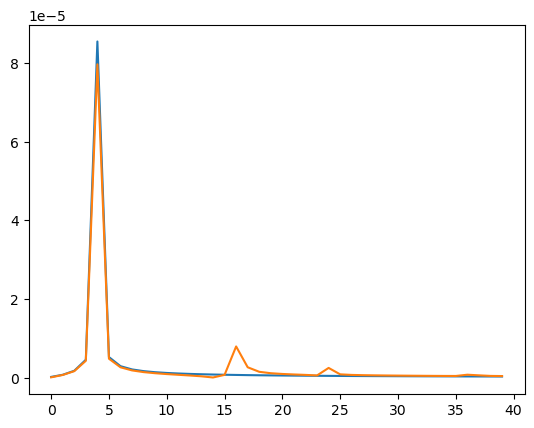

In [307]:
plt.plot(np.abs(np.fft.rfft(data1[:,200])[:40]))
plt.plot(np.abs(np.fft.rfft(data2[:,200])[:40]))

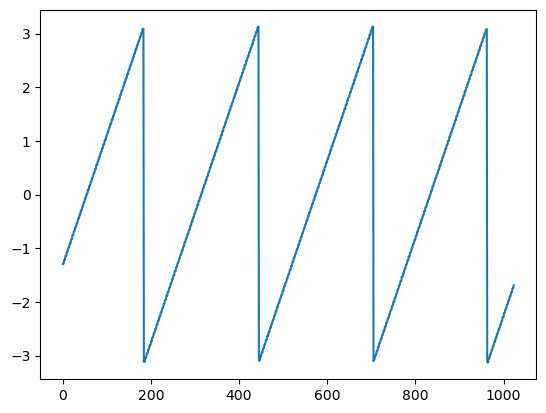

In [45]:
rez=[]
alpha_rms=[]
dblist = np.linspace(-60,0,10)
for dbsnr in dblist:
    snr = 10**(dbsnr/20)
    Nintg=128
    data = produce_data(alpha=+0.3,  Nintg=Nintg, sA=snr, add_noise=True)
    res = list(analyze_data(data,Nintg=Nintg, alpha_start=0.3, countmax = 12,  force_detect=True))
    rez.append(np.array([r[-1] for r in res]))
    alpha_rms.append(np.sqrt(np.array([r[3] for r in res]).var()))




-0.1845703125 -0.18172666876062607
0.0 9.415004000400042e-05
0.0 1.5235898589859367e-05
0.0 -1.0547929792979228e-05
0.0 -7.422617261726092e-06
0.0 5.859960996099957e-06
0.0 7.422617261726092e-06
0.0 4.297304730472955e-06
0.0 5.078632863286456e-06
0.0 5.078632863286456e-06


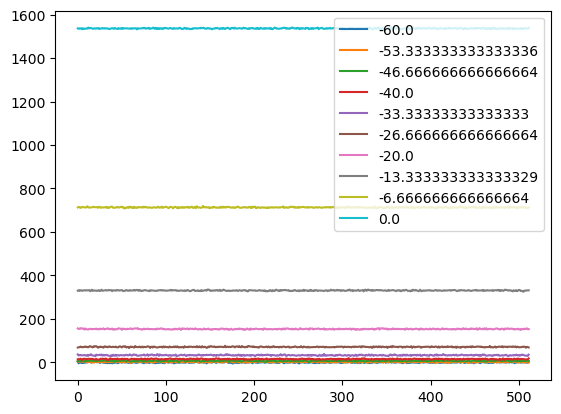

In [46]:
for rx,v in list(zip(rez,dblist)):
    a = phase_correct(rx.sum(axis=0))
    u = np.real(a*np.conj(code))
    if np.real(u[0])<0:
        u = -u

    plt.plot(u,label=str(v))


#plt.ylim(0,1.5)

plt.legend()


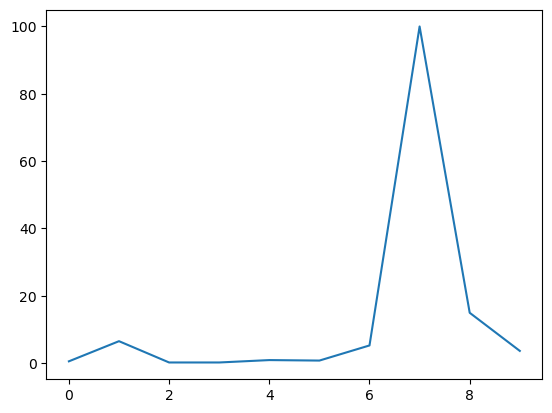

In [43]:
plt.plot(alpha_rms)